# **CNN Image Pre-Processing**



Defining necessary variables and importing libraries

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import os
import itertools
from keras.preprocessing import image
from PIL import Image, ImageDraw
import cv2
from scipy import ndimage
import csv

output = '/content/drive/My Drive/Thesis/Processed_Images'
angles1 = [36,50,72,108,144,180,216,252,288,324]
angles2 = [144,180]
angles3 = [72]
width = 300
height = 300

Unzipping original image folder (this has to be done everytime the session restarts)

In [0]:
!unzip /content/drive/My\ Drive/Thesis/images.zip

Masking and rotating **training images** belonging to class '0' (uninfected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==0')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles1:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)
        cv2.waitKey(2)

Masking and rotating **training images** belonging to class '1' (infected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==1')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles2:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)
        cv2.waitKey(2)

Masking and rotating **test images** belonging to class '0' (uninfected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==0')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles1:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)
        cv2.waitKey(2)

Masking and rotating **test images** belonging to class '1' (infected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==1')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles3:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)
        cv2.waitKey(2)

# **Modifying csv files as per new image name with angle concatenated at the front**

The output form this code returns just the image names concatenated with respective angle. Vlookup was then applied in excel to original file to fetch respective classes.

Modifying trainng csv file

In [0]:
with open('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv','r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    next(reader)
    with open('/content/drive/My Drive/Thesis/Train_Categorized.csv', 'w', newline='') as writefile:
        writer = csv.writer(writefile, delimiter=',')
        for line in reader:
            if line[1] == str(0):
                for x in angles1:
                    writer.writerow([str(x)+'_'+line[0]])
            else:
                for a in angles2:
                    writer.writerow([str(a)+'_'+line[0]])

Modifying test csv file

In [0]:
with open('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv','r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    next(reader)
    with open('/content/drive/My Drive/Thesis/Test_Categorized.csv', 'w', newline='') as writefile:
        writer = csv.writer(writefile, delimiter=',')
        for line in reader:
            if line[1] == str(0):
                for x in angles1:
                    writer.writerow([str(x)+'_'+line[0]])
            else:
                for a in angles3:
                    writer.writerow([str(a)+'_'+line[0]])

# **Convolutional Neural Network for Image Classification**

Loading and storing training images in numpy array

In [0]:
train = pd.read_csv('/content/drive/My Drive/Thesis/Train_Categorized.csv')

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('/content/drive/My Drive/Thesis/Processed_Images/'+str(train['image'][i])+'.png', target_size=(132,132,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    img = cv2.GaussianBlur(img, (5, 5), 10)
    train_image.append(img)
    cv2.waitKey(5)
X = np.array(train_image)

100%|██████████| 3928/3928 [00:20<00:00, 189.54it/s]


Changing class labels to categorical

In [0]:
y=train['category'].values
y = to_categorical(y)

Preparing training and validation sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Sequential Model

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='relu'))

This is not mandatory, it is just in case one wants to see the model in a flow chart form. A png image will be saved in your current working directory

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Compiling and fitting the model for 20 epochs

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Train on 3142 samples, validate on 786 samples
Epoch 1/20
3142/3142 [==============================] - 9s 3ms/step - loss: 7.4085 - acc: 0.5271 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 2/20
3142/3142 [==============================] - 6s 2ms/step - loss: 7.4383 - acc: 0.5264 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 3/20
3142/3142 [==============================] - 7s 2ms/step - loss: 7.3819 - acc: 0.5306 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 4/20
3142/3142 [==============================] - 7s 2ms/step - loss: 7.4229 - acc: 0.5315 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 5/20
3142/3142 [==============================] - 6s 2ms/step - loss: 7.4332 - acc: 0.5296 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 6/20
3142/3142 [==============================] - 7s 2ms/step - loss: 7.4024 - acc: 0.5299 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 7/20
3142/3142 [==============================] - 7s 2ms/step - loss: 7.4127 - acc: 0.5286 - val_loss: 8.4487 - val_acc: 0.4758
Epoch 8/20
3142

Plots for training accuracy and loss and validation accuracy and loss

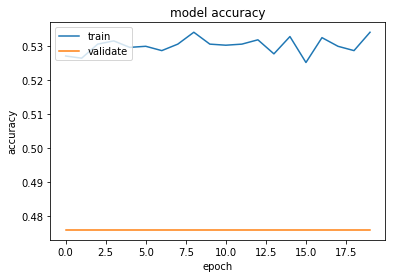

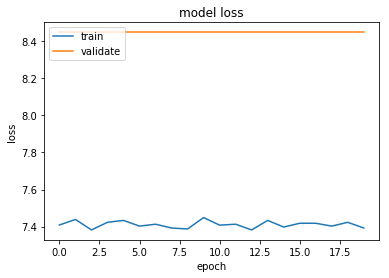

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

Loading and storing test images in numpy array

In [0]:
test = pd.read_csv('/content/drive/My Drive/Thesis/Test_Categorized.csv')

test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('/content/drive/My Drive/Thesis/Processed_Images/'+str(test['image'][i])+'.png', target_size=(132,132,3), grayscale=False)
    img = image.img_to_array(img)
    img = cv2.GaussianBlur(img, (5, 5), 10)
    img = img/255
    test_image.append(img)
    cv2.waitKey(2)
test_set = np.array(test_image)

x=test['category'].values

100%|██████████| 147/147 [00:00<00:00, 200.47it/s]


Making predictions on test images

In [0]:
prediction = model.predict_classes(test_set,verbose=0)
accuracy = accuracy_score(test['category'],prediction)
print('Accuracy: ', accuracy*100, '%')

Accuracy:  79.59183673469387 %


Function to build readable friendly confusion matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Compute and plot confusion matrix

Confusion matrix, without normalization
[[  0  30]
 [  0 117]]


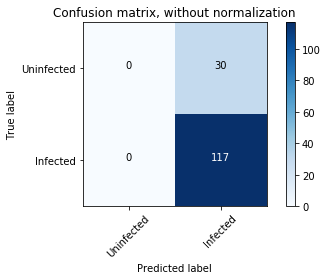

In [0]:
cnf_matrix = confusion_matrix(x,prediction)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Uninfected','Infected'],
                      title='Confusion matrix, without normalization')

Calculating Accuracy, Precision, Recall and F1-Score

In [0]:
print(classification_report(x,prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.80      1.00      0.89       117

    accuracy                           0.80       147
   macro avg       0.40      0.50      0.44       147
weighted avg       0.63      0.80      0.71       147



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
